In [1]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 491kB 49.0MB/s 
     |████████████████████████████████| 3.2MB 55.3MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 16.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import decode_predictions
from keras.applications.resnet import preprocess_input
from keras.models import Model,Sequential
from keras.layers import Input,UpSampling2D,Flatten,BatchNormalization,Dense,Dropout,GlobalAveragePooling2D
from keras import optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from PIL import Image

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
!nvidia-smi

Fri Jan 15 06:42:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data is under 'Advance Computer Vision - Part1' tab in dashboard name as 'Sample Dataset'

In [ ]:
!unzip /content/data.zip

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.


In [7]:
IMAGE_SIZE = [224, 224]#Give dataset path
train = '/content/drive/MyDrive/Deep Learning/CatDog/training_set'
test = '/content/drive/MyDrive/Deep Learning/CatDog/test_set'

In [8]:
# useful for getting number of classes
folders = glob('/content/drive/MyDrive/Deep Learning/CatDog/test_set/*')
print(len(folders))
num_classes = 2
nb_epochs = 10

2


In [9]:
# Fixed for our dataset
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

In [11]:
resnet=ResNet50(include_top=False, weights='imagenet',input_shape=IMAGE_SIZE + [3])


94773248/94765736 [==============================] - 1s 0us/step


In [12]:
from keras.models import Model,Sequential
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [16]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        '/content/drive/MyDrive/Deep Learning/CatDog/training_set',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')


validation_generator = data_generator.flow_from_directory(
        '/content/drive/MyDrive/Deep Learning/CatDog/test_set',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')

Found 5747 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


# Data Augmentation
test_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [18]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION
        
)


Epoch 1/10
10/10 [==============================] - 474s 47s/step - loss: 0.2844 - accuracy: 0.8733 - val_loss: 0.1583 - val_accuracy: 0.9580
Epoch 2/10
10/10 [==============================] - 461s 46s/step - loss: 0.0870 - accuracy: 0.9720 - val_loss: 0.0546 - val_accuracy: 0.9840
Epoch 3/10
10/10 [==============================] - 447s 45s/step - loss: 0.0590 - accuracy: 0.9740 - val_loss: 0.0442 - val_accuracy: 0.9783
Epoch 4/10
10/10 [==============================] - 447s 45s/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.0172 - val_accuracy: 0.9840
Epoch 5/10
10/10 [==============================] - 453s 45s/step - loss: 0.0590 - accuracy: 0.9770 - val_loss: 0.0211 - val_accuracy: 0.9848
Epoch 6/10
10/10 [==============================] - 473s 47s/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.0114 - val_accuracy: 0.9860
Epoch 7/10
10/10 [==============================] - 423s 42s/step - loss: 0.0449 - accuracy: 0.9850 - val_loss: 0.0042 - val_accuracy: 0.9913
Epoch

In [ ]:
model.save("mymodelresnet1.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
import numpy as np

from keras.preprocessing import image

In [20]:
from tensorflow.python.keras.models import load_model

In [21]:
test_image = image.load_img('/content/drive/MyDrive/Deep Learning/CatDog/test_set/dogs/dog.4004.jpg', target_size = (224, 224))

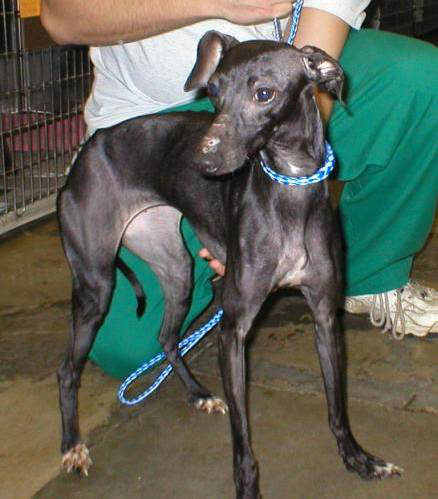

In [22]:
#show image
from IPython.display import display # to display images

img = Image.open('/content/drive/MyDrive/Deep Learning/CatDog/test_set/dogs/dog.4004.jpg')
display(img)

In [23]:
test_image = image.img_to_array(test_image)

In [24]:
test_image = np.expand_dims(test_image, axis = 0)

In [ ]:
model = load_model('mymodelresnet1.h5')

In [25]:
result = model.predict(test_image)

In [26]:
result = result[0]

In [27]:
classes = ['cat','dog']

label_name = {classes[i]: result[i] for i in range(len(result))}
label_name

{'cat': 3.1889547e-06, 'dog': 0.9999968}

In [28]:
output = max(label_name, key=label_name.get)
print(output)

dog


# New Section

# New Section